In [ ]:
#manipulate paths
import os

#Audio utilities libraries
from scipy.io import wavfile as wav
import librosa
import librosa.display
#import sounddevice as sd

#sklearn utilities 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

#numpy
import numpy as np

#pandas
import pandas as pd

#plot libraries
import matplotlib.pyplot as plt

#keras
import keras
from keras import Sequential
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy

# Classification

In [ ]:
def identity(input):
    return input

def load_data(feature_extractor=identity):

    labels = []
    features = []

    for f in sorted(os.listdir('./dataset')):
        if f.endswith('.wav'):
            _, signal = wav.read('./dataset/' + f)
            cur_features = feature_extractor(signal)
            features.append(cur_features)

            label = f.split('_')[0]
            labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

    return X_train, X_test, y_train, y_test

In [ ]:
# Feature Extractor
def mfcc(input, rate=44100, sampling=1):
    signal = input[::sampling]
    mfcc = librosa.feature.mfcc(signal*1.0, sr=int(rate/sampling))
    return mfcc

In [ ]:
rate, signal = wav.read('./dataset/alberto_1_20.wav')

In [ ]:
mfcc(signal).shape

(20, 173)

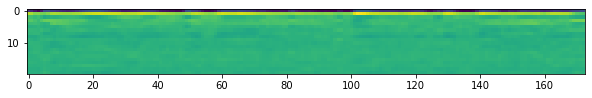

In [ ]:
# plot dei coefficienti con plt
plt.figure(figsize=(10, 10)) 
plt.imshow(mfcc(signal) )

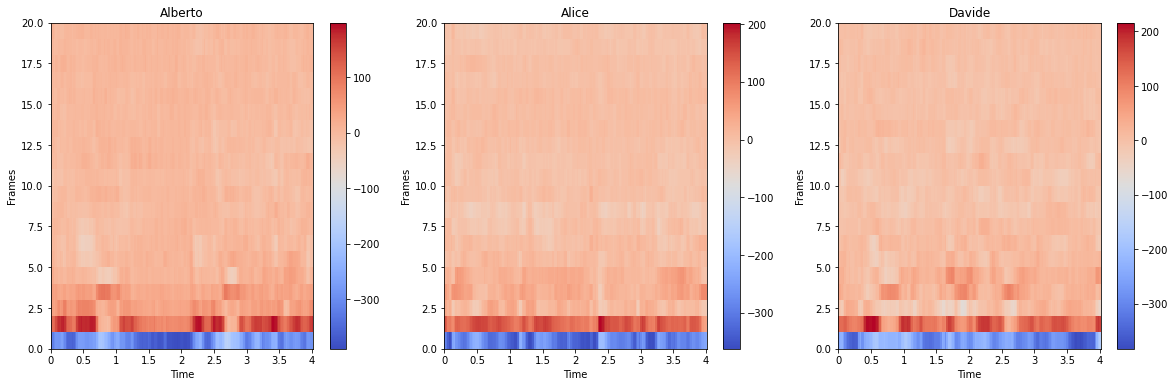

In [ ]:
# plot dei coefficienti con librosa.display
rate1,signal1 = wav.read('./dataset/alberto_1_20.wav')
rate2,signal2 = wav.read('./dataset/alice_1_20.wav')
rate3,signal3 = wav.read('./dataset/davide_1_20.wav')

plt.figure(figsize=(20, 6)) 
plt.subplot(1,3,1)
plt.title('Alberto')
librosa.display.specshow(librosa.feature.mfcc(signal1*1.0, sr=int(rate1/1)), x_axis='time', y_axis='frames')
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Alice')
librosa.display.specshow(librosa.feature.mfcc(signal2*1.0, sr=int(rate2/1)), x_axis='time', y_axis='frames')
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Davide')
librosa.display.specshow(librosa.feature.mfcc(signal3*1.0, sr=int(rate3/1)), x_axis='time', y_axis='frames')
plt.colorbar()

In [ ]:
# Creazione train, validation e test set
X_train, X_test, y_train, y_test = load_data(feature_extractor=mfcc)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

In [ ]:
X_train.shape

(1093, 20, 173)

In [ ]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],-1,1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],-1,1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],-1,1)

In [ ]:
X_train.shape

(1093, 20, 173, 1)

In [ ]:
# one-hot encoding
label_encoder = LabelEncoder()
y_train_ = label_encoder.fit_transform(y_train)
y_val_ = label_encoder.fit_transform(y_val)
y_test_ = label_encoder.fit_transform(y_test)

Y_train = np_utils.to_categorical(y_train_,3)
Y_val = np_utils.to_categorical(y_val_,3)
Y_test = np_utils.to_categorical(y_test_,3)

In [ ]:
X_train[0].shape

(20, 173, 1)

In [ ]:
dims=X_train[0].shape

In [ ]:
# modello CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(dims[0], dims[1], dims[2])))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 85, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 83, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 41, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 39, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 2496)              0

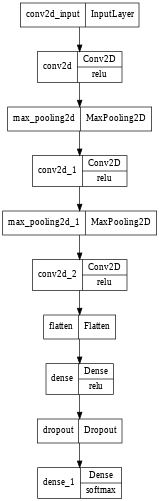

In [ ]:
plot_model(model, to_file='cnn_model.png', rankdir='TB', dpi=48, show_layer_activations=True)

In [ ]:
n_epochs=50

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, 
                    Y_train, 
                    batch_size=32,
                    epochs=n_epochs, 
                    validation_data=(X_val, Y_val))

Epoch 1/50
35/35 [==============================] - 3s 73ms/step - loss: 1.5179 - accuracy: 0.5627 - val_loss: 0.4132 - val_accuracy: 0.8279
Epoch 2/50
35/35 [==============================] - 2s 62ms/step - loss: 0.3637 - accuracy: 0.8527 - val_loss: 0.1670 - val_accuracy: 0.9262
Epoch 3/50
35/35 [==============================] - 2s 62ms/step - loss: 0.2472 - accuracy: 0.9149 - val_loss: 0.0843 - val_accuracy: 0.9836
Epoch 4/50
35/35 [==============================] - 2s 64ms/step - loss: 0.0803 - accuracy: 0.9698 - val_loss: 0.0257 - val_accuracy: 0.9918
Epoch 5/50
35/35 [==============================] - 2s 69ms/step - loss: 0.0661 - accuracy: 0.9707 - val_loss: 0.0225 - val_accuracy: 1.0000
Epoch 6/50
35/35 [==============================] - 2s 63ms/step - loss: 0.0256 - accuracy: 0.9936 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 7/50
35/35 [==============================] - 2s 62ms/step - loss: 0.0382 - accuracy: 0.9899 - val_loss: 0.0572 - val_accuracy: 0.9672
Epoch 8/50
35

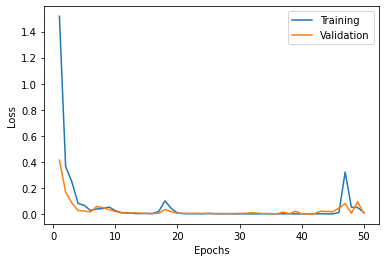

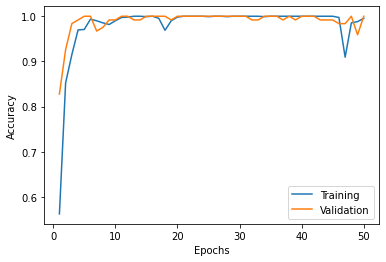

In [ ]:
x_plot = list(range(1,n_epochs+1))

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()


plot_history(history)

In [ ]:
score = model.evaluate(X_test, Y_test, batch_size=16)
print('val loss, val acc:', score)

9/9 [==============================] - 0s 14ms/step - loss: 0.0027 - accuracy: 1.0000
val loss, val acc: [0.0027156276628375053, 1.0]


In [ ]:
predictions = model.predict(X_test)
y_classes = (predictions > 0.5).astype(np.int8)
print(np.equal(y_classes, np.round(predictions)).all())

True


In [ ]:
print(classification_report(y_classes, Y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      1.00      1.00        44
           2       1.00      1.00      1.00        40

   micro avg       1.00      1.00      1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135
 samples avg       1.00      1.00      1.00       135



In [ ]:
model.save("mod_voce.h5")